In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, f1_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [19]:
from google.colab import files
uploaded = files.upload()

Saving dataset-20260213T084707Z-3-001.zip to dataset-20260213T084707Z-3-001.zip


In [20]:
! unzip dataset-20260213T084707Z-3-001.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Training/meningioma/Tr-me_0946.jpg  
  inflating: dataset/Training/meningioma/Tr-me_0951.jpg  
  inflating: dataset/Training/meningioma/Tr-me_1040.jpg  
  inflating: dataset/Training/meningioma/Tr-me_1167.jpg  
  inflating: dataset/Training/meningioma/Tr-me_0861.jpg  
  inflating: dataset/Training/meningioma/Tr-me_1182.jpg  
  inflating: dataset/Training/meningioma/Tr-me_1129.jpg  
  inflating: dataset/Training/meningioma/Tr-me_1008.jpg  
  inflating: dataset/Training/meningioma/Tr-me_0856.jpg  
  inflating: dataset/Training/meningioma/Tr-me_0970.jpg  
  inflating: dataset/Training/meningioma/Tr-me_0847.jpg  
  inflating: dataset/Training/meningioma/Tr-me_1026.jpg  
  inflating: dataset/Training/meningioma/Tr-me_0860.jpg  
  inflating: dataset/Training/meningioma/Tr-me_0973.jpg  
  inflating: dataset/Training/meningioma/Tr-me_1108.jpg  
  inflating: dataset/Training/meningioma/Tr-me_1006.jpg  
  inflating: dataset/

In [21]:
os.listdir()


['.config', 'dataset', 'dataset-20260213T084707Z-3-001.zip', 'sample_data']

In [24]:
os.listdir('dataset')

['.DS_Store', 'Training', 'Testing']

In [26]:
train_dir = "/content/dataset/Training"
test_dir = "/content/dataset/Testing"

In [27]:
os.listdir(train_dir)

['glioma', 'notumor', 'pituitary', '.DS_Store', 'meningioma']

In [28]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [30]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4572 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [31]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [33]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])


In [34]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [35]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.7029 - loss: 0.7127 - val_accuracy: 0.7862 - val_loss: 0.5599
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.8744 - loss: 0.3359 - val_accuracy: 0.8019 - val_loss: 0.5338
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.8707 - loss: 0.3310 - val_accuracy: 0.7914 - val_loss: 0.5507
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.8862 - loss: 0.3065 - val_accuracy: 0.8116 - val_loss: 0.5410
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9016 - loss: 0.2653

KeyboardInterrupt: 

In [37]:
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)

41/41 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8291 - loss: 0.4254
Test Accuracy: 0.859649121761322


In [38]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

from sklearn.metrics import classification_report, f1_score

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)


41/41 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step
              precision    recall  f1-score   support

      glioma       0.82      0.90      0.86       300
  meningioma       0.84      0.59      0.70       306
     notumor       0.92      0.94      0.93       405
   pituitary       0.83      0.98      0.90       300

    accuracy                           0.86      1311
   macro avg       0.85      0.85      0.85      1311
weighted avg       0.86      0.86      0.85      1311

Macro F1 Score: 0.8471720374238259


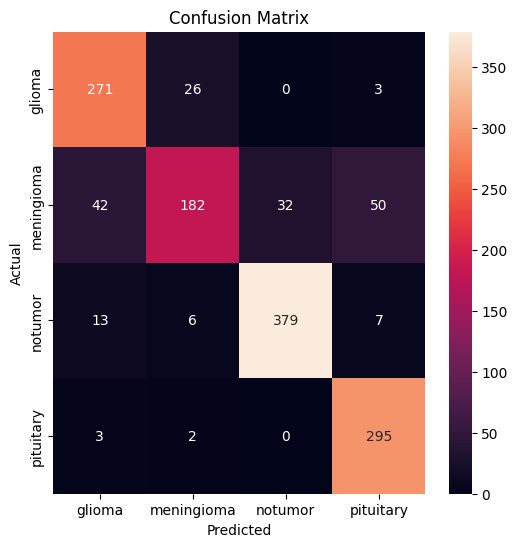

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [43]:
import os
import pandas as pd

filenames = test_generator.filenames
labels = list(test_generator.class_indices.keys())

predicted_classes = [labels[i] for i in y_pred]

submission = pd.DataFrame({
    "ImageId": [os.path.basename(f) for f in filenames],
    "Class": predicted_classes
})

submission.to_csv("submission.csv", index=False)

In [44]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>